## Load AudioSet data from file

Data extracted by:
https://github.com/qiuqiangkong/audioset_classification

In [47]:
# Load files
from pathlib import Path
import pickle
import numpy as np

base_dir = "./features/"

load_file = f"{base_dir}x_train_new.pkl"
with open(load_file, "rb") as load_file:
    x_train = pickle.load(load_file)
    
load_file = f"{base_dir}y_train_new.pkl"
with open(load_file, "rb") as load_file:
    y_train = pickle.load(load_file)
    
load_file = f"{base_dir}X_eval_new.pkl"
with open(load_file, "rb") as load_file:
    x_eval = pickle.load(load_file)
    
load_file = f"{base_dir}y_eval_new.pkl"
with open(load_file, "rb") as load_file:
    y_eval = pickle.load(load_file)
    
load_file = f"{base_dir}X_unbal_new.pkl"
with open(load_file, "rb") as load_file:
    x_unbal = pickle.load(load_file)
    
load_file = f"{base_dir}y_unbal_new.pkl"
with open(load_file, "rb") as load_file:
    y_unbal = pickle.load(load_file)

In [48]:
# Select the classes we want
import pandas as pd

classes_file = "../dataset/class_labels_indices.csv"

df = pd.read_csv(classes_file)
df = df.set_index('index')
selected_classes = ["Vehicle horn, car horn, honking", "Children playing", "Dog", "Jackhammer", "Siren", 
                    "Vehicle", "Rail transport", "Walk, footsteps", "Speech", "Bird"]

df_sel = df[df['display_name'].isin(selected_classes)]
df_sel.head(10)

,mid,display_name
index,,
0,/m/09x0r,Speech
53,/m/07pbtc8,"Walk, footsteps"
71,/t/dd00013,Children playing
74,/m/0bt9lr,Dog
111,/m/015p6,Bird
300,/m/07yv9,Vehicle
308,/m/0912c9,"Vehicle horn, car horn, honking"
328,/m/06d_3,Rail transport
396,/m/03kmc9,Siren


In [25]:
filter_classes = list(df_sel.index)

y_train_filtered = y_train[:,filter_classes]

# Rows that contain only ONE of our classes (There are 264 datapints with 2 classes or more)
filter = np.argwhere(np.sum(y_train_filtered, axis=1) == 1)
y_train = y_train_filtered[filter.flat]
x_train = x_train[filter.flat]

y_eval_filtered = y_eval[:,filter_classes]

filter = np.argwhere(np.sum(y_eval_filtered, axis=1) == 1)
y_eval = y_eval_filtered[filter.flat]
x_eval = x_eval[filter.flat]

y_unbal_filtered = y_unbal[:,filter_classes]

filter = np.argwhere(np.sum(y_unbal_filtered, axis=1) == 1)
y_unbal = y_unbal_filtered[filter.flat]
x_unbal = x_unbal[filter.flat]

In [36]:
import matplotlib.pyplot as plt

counters = {}
counters_values = []
for i in y_train:
    for k in i:
        if k in counters_values:
            counters[df.iloc[k]['display_name']] += 1
        else: 
            counters[df.iloc[k]['display_name']] = 0
            counters_values.append(k)

In [60]:
filter_classes = list(df_sel.index)

y_train_filtered = y_train[:,filter_classes]

# Rows that contain only ONE of our classes (There are 264 datapints with 2 classes or more) 7112-6563
filter = np.argwhere(np.sum(y_train_filtered, axis=1) == 1)

In [65]:
y_train_filtered[filter.flat].sum(axis=0)

array([5217,   26,    2,  180,  150,  546,   17,  181,  206,   38])

In [66]:
X = np.concatenate((x_train, x_unbal))
y = np.concatenate((y_train, y_unbal))

In [70]:
filter_classes = list(df_sel.index)

y_filtered = y[:,filter_classes]

# Rows that contain only ONE of our classes (There are 264 datapints with 2 classes or more) 7112-6563
filter = np.argwhere(np.sum(y_filtered, axis=1) == 1)
y_filtered[filter.flat].sum(axis=0)

array([943791,    673,     26,   6986,  18057,  77929,   1236,   4025,
         7077,    142])

In [27]:
import keras
from keras import callbacks
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Activation, Lambda
import keras.backend as K
import tensorflow as tf

def auroc(y_true, y_pred):
    return tf.numpy_function(roc_auc_score, (y_true, y_pred), tf.double)

def attention_pooling(inputs, **kwargs):
    [out, att] = inputs

    epsilon = 1e-7
    att = K.clip(att, epsilon, 1. - epsilon)
    normalized_att = att / K.sum(att, axis=1)[:, None, :]

    return K.sum(out * normalized_att, axis=1)

def pooling_shape(input_shape):

    if isinstance(input_shape, list):
        (sample_num, time_steps, freq_bins) = input_shape[0]

    else:
        (sample_num, time_steps, freq_bins) = input_shape

    return (sample_num, freq_bins)

time_steps = 10
freq_bins = 128
classes_num = 10

# Hyper parameters
hidden_units = 1024
drop_rate = 0.5
batch_size = 500

# Embedded layers
input_layer = Input(shape=X[0].shape)

a1 = Dense(hidden_units)(input_layer)
a1 = BatchNormalization()(a1)
a1 = Activation('relu')(a1)
a1 = Dropout(drop_rate)(a1)

a2 = Dense(hidden_units)(a1)
a2 = BatchNormalization()(a2)
a2 = Activation('relu')(a2)
a2 = Dropout(drop_rate)(a2)

a3 = Dense(hidden_units)(a2)
a3 = BatchNormalization()(a3)
a3 = Activation('relu')(a3)
a3 = Dropout(drop_rate)(a3)
cla = Dense(hidden_units, activation='linear')(a3)
att = Dense(hidden_units, activation='sigmoid')(a3)

b1 = Lambda(attention_pooling, output_shape=pooling_shape)([cla, att])
b1 = BatchNormalization()(b1)
b1 = Activation(activation='relu')(b1)
b1 = Dropout(drop_rate)(b1)

output_layer = Dense(classes_num, activation='sigmoid')(b1)

model = keras.Model(inputs=input_layer, outputs=output_layer, name="qiuqiangkong")
model.compile(loss='binary_crossentropy', optimizer="Adam", metrics=["accuracy"])
model.summary()

Model: "qiuqiangkong"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 128)]    0           []                               
                                                                                                  
 dense_6 (Dense)                (None, 10, 1024)     132096      ['input_2[0][0]']                
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 10, 1024)    4096        ['dense_6[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 activation_4 (Activation)      (None, 10, 1024)     0           ['batch_normalization_

In [28]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)


history = model.fit(
    x_train,
    y_train,
    batch_size=64, # batch size 1 doesn't work
    epochs=100,
    validation_data=(x_eval, y_eval),
    callbacks =[earlystopping]
)

Epoch 1/100
103/103 [==============================] - 8s 54ms/step - loss: 0.1199 - accuracy: 0.8414 - val_loss: 0.0822 - val_accuracy: 0.8560
Epoch 2/100
103/103 [==============================] - 24s 239ms/step - loss: 0.0662 - accuracy: 0.8909 - val_loss: 0.0716 - val_accuracy: 0.8747
Epoch 3/100
103/103 [==============================] - 11s 105ms/step - loss: 0.0569 - accuracy: 0.9075 - val_loss: 0.0899 - val_accuracy: 0.8804
Epoch 4/100
103/103 [==============================] - 24s 239ms/step - loss: 0.0508 - accuracy: 0.9096 - val_loss: 0.0875 - val_accuracy: 0.8886
Epoch 5/100
103/103 [==============================] - 18s 172ms/step - loss: 0.0470 - accuracy: 0.9174 - val_loss: 0.0720 - val_accuracy: 0.8993
Epoch 6/100
103/103 [==============================] - 24s 236ms/step - loss: 0.0422 - accuracy: 0.9270 - val_loss: 0.0686 - val_accuracy: 0.8956
Epoch 7/100
103/103 [==============================] - 28s 268ms/step - loss: 0.0383 - accuracy: 0.9299 - val_loss: 0.0743 - v

In [29]:
models_dir = "./models/"

model.save_weights(f"{models_dir}qiuqiangkong_b64_hdf5_new_weights.tf")

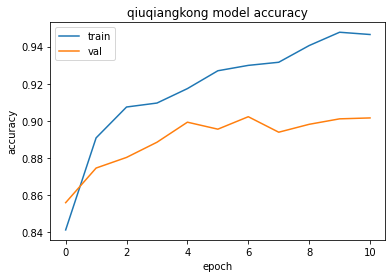

In [30]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('qiuqiangkong model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

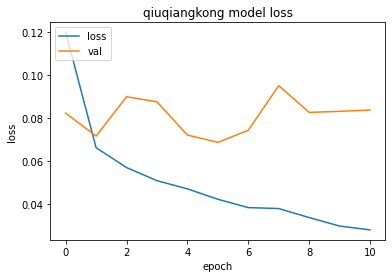

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('qiuqiangkong model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val'], loc='upper left')
plt.show()

In [32]:
# Generate predictions
y_pred = model.predict(x_eval)

In [33]:
# Transform one hot encoding to a series of ints for confusion matrix

y_pred = np.argmax(y_pred, axis=1)
y_eval_transformed = np.argmax(y_eval, axis=1)

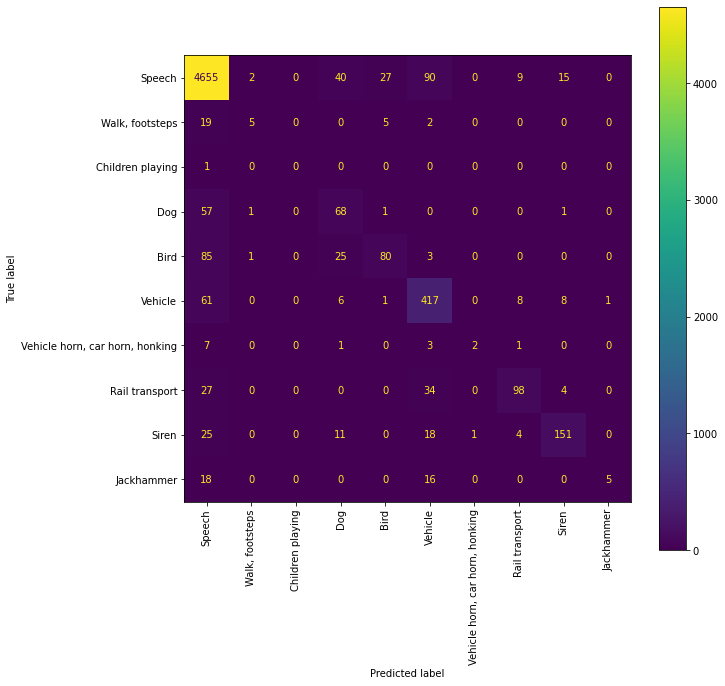

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay.from_predictions(y_eval_transformed, y_pred, display_labels=[df.iloc[y]["display_name"] for y in filter_classes], 
                              xticks_rotation='vertical', ax=ax)